# SnSe example
In this tutorial we are going to study the thermoelectric transition in SnSe.
To speedup the calculations, we will use a force-field that correctly reproduces the physics of ferroelectric transition in Fcc lattice.

We will replicate the calculations performed in the paper by [Bianco et. al. Phys. Rev. B 96, 014111](https://journals.aps.org/prb/abstract/10.1103/PhysRevB.96.014111).

The force field can be downloaded and installed from [here](https://github.com/mesonepigreco/F3ToyModel). 

## Initialization
As always, we need to initialize the working space.
This time we will initialize first the force field.
This force field needs the harmonic dynamical matrix to be initialized, and the higher parameters.
We will initialize it in order to reproduce the same as in [Bianco et. al. Phys. Rev. B 96, 014111](https://journals.aps.org/prb/abstract/10.1103/PhysRevB.96.014111).


In [1]:
# Import the cellconstructor stuff
import cellconstructor as CC
import cellconstructor.Phonons

# Import the modules of the force field
import fforces as ff
import fforces.Calculator

# Import the modules to run the sscha
import sscha, sscha.Ensemble, sscha.SchaMinimizer
import sscha.Relax, sscha.Utilities

# Load the dynamical matrix for the force field
ff_dyn = CC.Phonons.Phonons("ffield_dynq", 3)

# Setup the forcefield with the correct parameters
ff_calculator = ff.Calculator.ToyModelCalculator(ff_dyn)
ff_calculator.type_cal = "pbtex"
ff_calculator.p3 = 0.036475
ff_calculator.p4 = -0.022
ff_calculator.p4x = -0.014

/home/darth-vader/.local/lib/python2.7/site-packages/fforces/Calculator.py:62: ComplexWarning: Casting complex values to real discards the imaginary part
  self.phi_sc_harmonic[:, :, i, j] = phi_sc[3*i:3*i+3, 3*j:3*j+3]


We initialized a force field, for a detailed explanations of the parameters, refer to the [Bianco et. al. Phys. Rev. B 96, 014111](https://journals.aps.org/prb/abstract/10.1103/PhysRevB.96.014111) paper.
Now ff_calculator behaves like any [ASE](https://wiki.fysik.dtu.dk/ase/) calculator, and can be used to compute forces and energies for our SSCHA. 
Note: this force field is not able to compute stress, as it is defined only at fixed volume, so we cannot use it for a variable cell relaxation.

Now it is the time to initialize the SSCHA. 
We can start from the harmonic dynamical matrix we got for the force field. Remember, SSCHA dynamical matrices must be positive definite.
Since we are studying a system that has a spontaneous symmetry breaking at low temperature, the harmonic dynamical matrices will have imaginary phonons.
We must enforce phonons to be positive definite to start a SSCHA.

In [2]:
# Initialization of the SSCHA matrix
dyn_sscha = ff_dyn.Copy()
dyn_sscha.ForcePositiveDefinite()

# Apply also the ASR and the symmetry group
dyn_sscha.Symmetrize()

We must now prepare the sscha ensemble for the minimization. 
We will start with a $T= 0K$ simulation

In [3]:
ensemble = sscha.Ensemble.Ensemble(dyn_sscha, T0 = 0, supercell = dyn_sscha.GetSupercell())

We can now proceed with the sscha minimization.
Since we start from a dynamical matrix that is very far from the correct result, it is convenient to use a safer minimization scheme.
We will use the fourth root minimization, in which, instead of optimizing the dynamical matrix itself, we will optimize its fourth root.
Then the dynamical matrix $\Phi$ will be obtained as:

$$
\Phi = \left(\sqrt[4]{\Phi}\right)^4
$$

This constrains $\Phi$ to be positive definite during the minimization. Moreover, this minimization is more stable than the standard one. If you want further details, please look at [Monacelli et. al. Phys. Rev. B 98, 024106](https://journals.aps.org/prb/abstract/10.1103/PhysRevB.98.024106).

We also change the Kong-Liu effective sample size threshold. This is a value tha decrease during the minimization, as the parameters gets far away from the starting point. It estimates how the original ensemble is good to describe the new parameters. If this value goes below a give threshold, the minimization is stopped, and a new ensemble is extracted.

In [4]:
minim = sscha.SchaMinimizer.SSCHA_Minimizer(ensemble)

# Lets setup the minimization on the fourth root
minim.root_representation = "root4" # Other possibilities are 'normal' and 'sqrt'

# To work correctly with the root4, we must deactivate the preconditioning on the dynamical matrix 
minim.precond_dyn = False

# Now we setup the minimization parameters
# Since we are quite far from the correct solution, we will use a small optimization step
minim.min_step_dyn = 1 # If the minimization ends with few steps (less than 10), decrease it, if it takes too much, increase it

# We decrease the Kong-Liu effective sample size below which the population is stopped
minim.kong_liu_ratio = 0.2 # Default 0.5 

We can setup the automatic relaxation, to avoid the need to restart the frequencies at each iteration.
We will also setup a custom function to save the frequencies at each iteration, to see how they evolves.
This is very usefull to understand if the algorithm is converged or not.

We will use ensembles of 1000 configurations for each population, and a maximum of 20 populations.

In [5]:
relax = sscha.Relax.SSCHA(minim, 
                          ase_calculator = ff_calculator,
                          N_configs = 1000, 
                          max_pop = 20)

# Setup the custom function to print the frequencies at each step of the minimization
io_func = sscha.Utilities.IOInfo()
io_func.SetupSaving("frequencies.dat") # The file that will contain the frequencies is frequencies.dat

# Now tell relax to call the function to save the frequencies after each iteration
# CFP stands for Custom Function Post (Post = after the minimization step)
relax.setup_custom_functions(custom_function_post = io_func.CFP_SaveFrequencies)

We are ready to start the SSCHA minimization. This may take few minutes, depending on how powerfull is your PC. 
If you do not want to run this on your machine, skip it and pass to the following .

In [ ]:
relax.relax()

# Save the final dynamical matrix
relax.minim.dyn.save_qe("final_sscha_T0_")

## Plotting the results
We can plot the evolution of the frequencies, as well as the Free energy and the gradient to see if the minimization ended correctly.


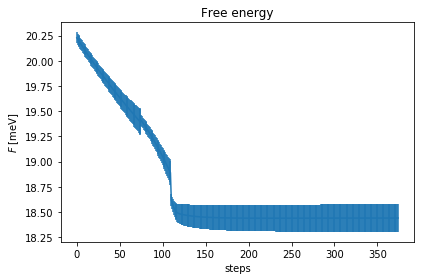

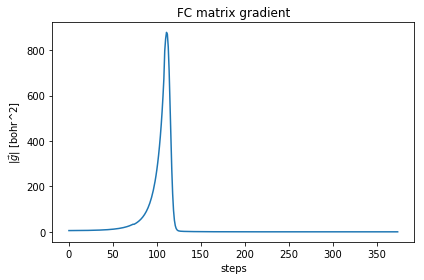

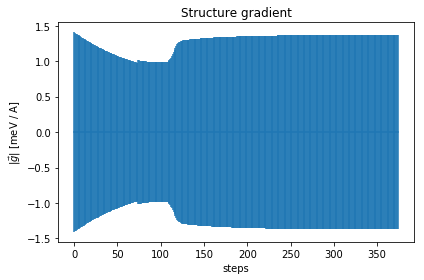

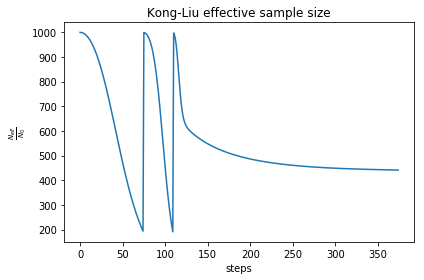

In [7]:
# Import Matplotlib to plot
import numpy as np
import matplotlib.pyplot as plt

# Setup the interactive plotting mode
plt.ion()

# Lets plot the Free energy, gradient and the Kong-Liu effective sample size
relax.minim.plot_results()

As you can see, the free energy always decreases, and reaches a plateaux. The gradient at the beginning increases, then it goes to zero very fast close to convergence.
To have an idea on how good is the ensemble, check the Kong-Liu effective sample size (the last plot). We can see that we went two times below the convergence threshold of 0.2 (200 out of 1000 configuration), this means that the we required three calculations.
We have at the end 500 good configurations out of the original 1000. This means that the ensemble is still at its 50 % of efficiency.

Lets have a look on how the frequencies evolve now, by loading the frequencies.dat file that we created.

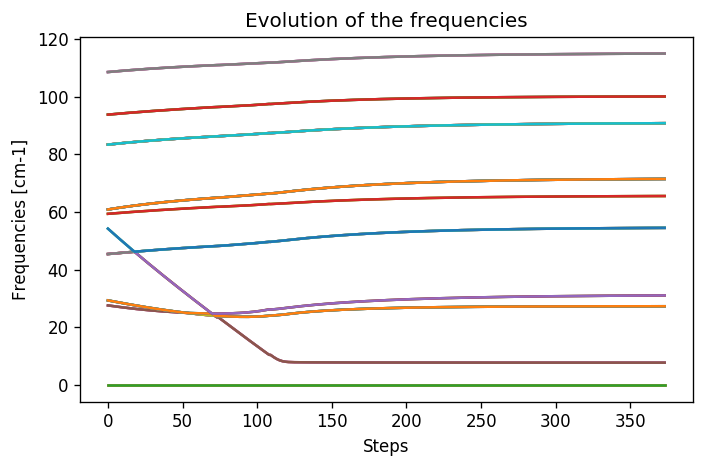

In [8]:
frequencies = np.loadtxt("frequencies.dat")
N_steps, N_modes = frequencies.shape

#For each frequency, we plot it [we convert from Ry to cm-1]
plt.figure(dpi = 120)
for i_mode in range(N_modes):
    plt.plot(frequencies[:, i_mode] * CC.Units.RY_TO_CM)
plt.xlabel("Steps")
plt.ylabel("Frequencies [cm-1]")
plt.title("Evolution of the frequencies")
plt.tight_layout()

While at the beginning the frequencies was changing a lot, in the last population they changed more smoothly. 
This is a good sign that they are converged. One frequency has a very small value. 
The cusps in the frequencies is the point in which we changed the ensemble. In the minimization we provided, this happened once sligtly above step 100, in correspondance with the change of the ensemble into the last one.
We reached the final results with only 3 ensembles (3000 configurations energy/forces calculations).

# The instability
From the frequencies, we can see that we have one SSCHA frequency that is very low, below 10 cm-1.
This is probabily a sign of instability.
We remark: the sscha frequencies are not the real frequencies observed in experiments, but rather are linked to the average displacements of atoms along that mode:
In particular the average displacements of atoms can be computed from sscha frequencies as (includes both thermal and quantum fluctuations):
$$
\sigma_\mu = \sqrt{ \frac{1 + 2n_\mu}{2\omega_\mu}}
$$
where $n_\mu$ is the boson occupation number and $\omega_\mu$ is the SSCHA frequency.

It is clear, that $\omega_\mu$ will always be positive, even if we have an instability. Since we have a very small mode in the SCHA frequencies, it means that associated to that mode we have huge fluctuations. This can indicate an instability.
However, to test this we need to compute the free energy curvature along this mode. This can be obtained in one shot thanks to the theory developed in [Bianco et. al. Phys. Rev. B 96, 014111](https://journals.aps.org/prb/abstract/10.1103/PhysRevB.96.014111). 

First of all, we generate a new ensemble with more configurations. To compute the hessian we will use an ensemble of 10000 configurations.

In [ ]:
# We reload the final result (no need to rerun the sscha minimization)
dyn_sscha_final = CC.Phonons.Phonons("final_sscha_T0_", 3)

# We reset the ensemble
ensemble = sscha.Ensemble.Ensemble(dyn_sscha_final, T0 = 0, supercell = dyn_sscha_final.GetSupercell())

# We need a bigger ensemble to properly compute the hessian
# Here we will use 10000 configurations
ensemble.generate(10000)

# We now compute forces and energies using the force field calculator
ensemble.get_energy_forces(ff_calculator, compute_stress = False)

Now we can proceed to compute the Free energy hessian. 
We can choose if neglect or not in the calculation four phonon scattering process at higher order. Four phonon scattering processes require a huge memory allocation for big systems, that scales as $(3 \cdot N)^4$ with $N$ the number of atoms in the supercell. Moreover, it requires also more configurations to converge.

In almost all the system we studied up to now, we found this four phonon scattering at high order to be neglectable.
We remark, that the SSCHA minimization already includes four phonon scattering at the lowest order perturbation theory, thus neglecting this term only affects combinations of one or more four phonon scattering with two three phonon scatterings (high order dyagrams).
For more details, see [Bianco et. al. Phys. Rev. B 96, 014111](https://journals.aps.org/prb/abstract/10.1103/PhysRevB.96.014111). 


In [10]:
dyn_hessian = ensemble.get_free_energy_hessian(include_v4 = False) # We neglect high-order four phonon scattering

# We can save it
dyn_hessian.save_qe("hessian")

We can print the eigenmodes of the free energy hessian to check if there is an instability:

In [12]:
w_hessian, pols_hessian = dyn_hessian.DiagonalizeSupercell()

# Print all the frequency converting them into cm-1 (They are in Ry)
print("\n".join(["{:16.4f} cm-1".format(w * CC.Units.RY_TO_CM) for w in w_hessian]))

        -18.4862 cm-1
        -18.4862 cm-1
        -18.4862 cm-1
          0.0000 cm-1
          0.0000 cm-1
          0.0000 cm-1
         23.3091 cm-1
         23.3091 cm-1
         23.3091 cm-1
         23.3091 cm-1
         23.3091 cm-1
         23.3091 cm-1
         25.7898 cm-1
         25.7898 cm-1
         25.7898 cm-1
         48.9018 cm-1
         48.9018 cm-1
         48.9018 cm-1
         48.9018 cm-1
         48.9018 cm-1
         48.9018 cm-1
         48.9018 cm-1
         48.9018 cm-1
         52.5769 cm-1
         52.5769 cm-1
         52.5769 cm-1
         52.5769 cm-1
         52.5769 cm-1
         52.5769 cm-1
         64.6604 cm-1
         64.6604 cm-1
         64.6604 cm-1
         67.9293 cm-1
         67.9293 cm-1
         67.9293 cm-1
         67.9293 cm-1
         67.9293 cm-1
         67.9293 cm-1
         67.9293 cm-1
         67.9293 cm-1
         80.5268 cm-1
         80.5268 cm-1
         80.5268 cm-1
         80.5268 cm-1
        102.3613 cm-1
        10

Yes we have an immaginary phonons! We found an instability! You can check what happens if you include the fourth order.

# The phase transition

Up to now we studied the system at $T = 0K$ and we found that there is an instability. However, we can repeat the minimization at many temperatures, and track the phonon frequency to see which is the temperature at which the system becomes stable.

We can exploit the fact that our sscha package is a python library, and write a small script to automatize the calculation.

We will simulate the temperatures up to room temperature (300 K) with steps of 50 K.
Note, this will perform all the steps above 6 times, so it may take some minutes, depending on the PC ( on a i3 of.

In [ ]:
# Define the temperatures, from 50 to 300 K, 6 temperatures
temperatures = np.linspace(50, 300, 6)

lowest_hessian_mode = []
lowest_sscha_mode = []

# Perform a simulation at each temperature
t_old = 0
for T in temperatures:
    # Load the starting dynamical matrix
    dyn = CC.Phonons.Phonons("final_sscha_T{}_".format(int(t_old)), 3)
    
    # Prepare the ensemble
    ensemble = sscha.Ensemble.Ensemble(dyn, T0 = T, supercell = dyn.GetSupercell())
    
    # Prepare the minimizer 
    minim = sscha.SchaMinimizer.SSCHA_Minimizer(ensemble)
    minim.min_step_dyn = 0.002
    minim.kong_liu_ratio = 0.5
    #minim.root_representation = "root4"
    #minim.precond_dyn = False
    
    # Prepare the relaxer (through many population)
    relax = sscha.Relax.SSCHA(minim, ase_calculator = ff_calculator, N_configs=1000, max_pop=5)
    
    # Relax
    relax.relax()
    
    # Save the dynamical matrix
    relax.minim.dyn.save_qe("final_sscha_T{}_".format(int(T)))
    
    # Recompute the ensemble for the hessian calculation
    ensemble = sscha.Ensemble.Ensemble(relax.minim.dyn, T0 = T, supercell = dyn.GetSupercell())
    ensemble.generate(5000)
    ensemble.get_energy_forces(ff_calculator, compute_stress = False)
    
    # Get the free energy hessian
    dyn_hessian = ensemble.get_free_energy_hessian(include_v4 = False)
    dyn_hessian.save_qe("hessian_T{}_".format(int(T)))

    # Get the lowest frequencies for the sscha and the free energy hessian
    w_sscha, pols_sscha = relax.minim.dyn.DiagonalizeSupercell()
    # Get the structure in the supercell
    superstructure = relax.minim.dyn.structure.generate_supercell(relax.minim.dyn.GetSupercell()) #
    
    # Discard the acoustic modes
    acoustic_modes = CC.Methods.get_translations(pols_sscha, superstructure.get_masses_array())
    w_sscha = w_sscha[~acoustic_modes]
    
    lowest_sscha_mode.append(np.min(w_sscha) * CC.Units.RY_TO_CM) # Convert from Ry to cm-1
    
    w_hessian, pols_hessian = dyn_hessian.DiagonalizeSupercell()
    # Discard the acoustic modes
    acoustic_modes = CC.Methods.get_translations(pols_hessian, superstructure.get_masses_array())
    w_hessian = w_hessian[~acoustic_modes]
    lowest_hessian_mode.append(np.min(w_hessian) * CC.Units.RY_TO_CM) # Convert from Ry to cm-1
    
    t_old = T

# We prepare now the file to save the results
freq_data = np.zeros( (len(temperatures), 3))
freq_data[:, 0] = temperatures
freq_data[:, 1] = lowest_sscha_mode
freq_data[:, 2] = lowest_hessian_mode

# Save results on file
np.savetxt("hessian_vs_temperature.dat", freq_data, header = "T [K]; SSCHA mode [cm-1]; Free energy hessian [cm-1]")

We can now load and plot the results.


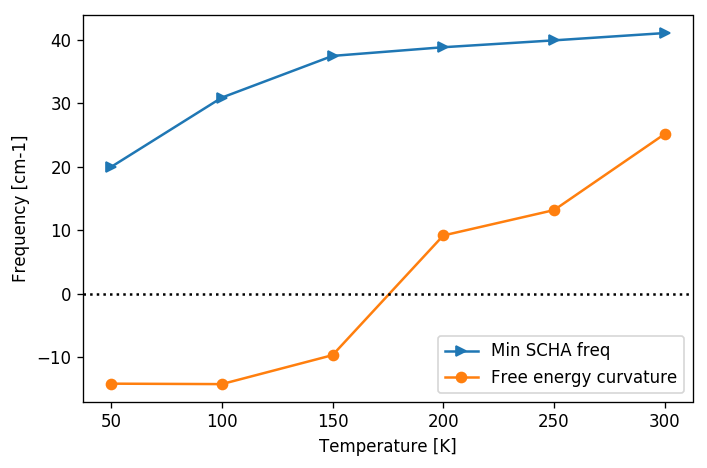

In [35]:
hessian_data = np.loadtxt("hessian_vs_temperature.dat")
plt.figure(dpi = 120)
plt.plot(hessian_data[:,0], hessian_data[:,1], label = "Min SCHA freq", marker = ">")
plt.plot(hessian_data[:,0], hessian_data[:,2], label = "Free energy curvature", marker = "o")
plt.axhline(0, 0, 1, color = "k", ls = "dotted") # Draw the zero
plt.xlabel("Temperature [K]")
plt.ylabel("Frequency [cm-1]")
plt.legend()
plt.tight_layout()

From the previous plot we can easily see that the phase transition occurs at about 170 K.
It is worth noting, as pointed out, that the SSCHA frequency is always positive definite, and no divergency is present in correspondance of the transition.
Moreover, the Free energy curvature is more noisy than the SSCHA one. Mainly because the error is bigger on small frequencies for the fact that:
$$
\omega \sim \sqrt{\Phi}
$$
But this is also due to the computation of the free energy curvature itself, that requires the third order force constant tensor, that requires more configurations to converge.

Be aware, if you study phase transition in charge density waves, like [NbS2](https://pubs.acs.org/doi/abs/10.1021/acs.nanolett.9b00504) or [TiSe2](https://arxiv.org/abs/1910.12709),
or thermoelectric materials like [SnSe](https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.122.075901) or [SnS](https://journals.aps.org/prb/abstract/10.1103/PhysRevB.100.214307) usually the transition temperature depends strongly on the supercell shape.

For the Landau theory of phase transition, since the SSCHA is a mean-field approach, we expect that around the transition the critical exponent of the temperature
$$
\omega \sim T^\frac 1 2
$$

Thus it is usually better to plot the temperature versus the square of the frequency:

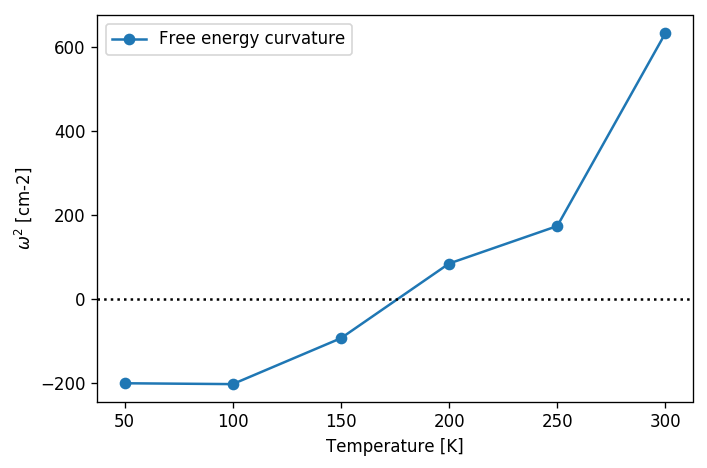

In [38]:
hessian_data = np.loadtxt("hessian_vs_temperature.dat")
plt.figure(dpi = 120)
plt.plot(hessian_data[:,0], np.sign(hessian_data[:,2]) * hessian_data[:,2]**2, label = "Free energy curvature", marker = "o")
plt.axhline(0, 0, 1, color = "k", ls = "dotted") # Draw the zero
plt.xlabel("Temperature [K]")
plt.ylabel("$\omega^2$ [cm-2]")
plt.legend()
plt.tight_layout()

As seen, the linear interpolation between 100 and 250 K is much better in this plot, allowing for a more precise determination of the transition temperature.